# Chapter 8 Notes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import seaborn as sns
from scipy.stats import norm

# Set seaborn style with custom configuration
sns.set_theme(
    style="whitegrid",
    rc={
        'axes.facecolor': 'white',
        'figure.facecolor': 'white',
        'axes.grid': True,
        'grid.alpha': 0.5,  # Major gridline opacity
        'axes.spines.top': True,
        'axes.spines.right': True,
        'axes.spines.bottom': True,
        'axes.spines.left': True
    }
)

def set_minor_grid(ax):
    """Helper function to add minor gridlines with lower opacity"""
    ax.grid(which='minor', alpha=0.2)
    ax.minorticks_on()

## 8.2 The Bootstrap and Maximum Likelihood Methods

### 8.2.1 A Smoothing Example

Suppose that we have one dimensional data $\mathbb{Z}=\lbrace z_1, \ldots, z_N\rbrace$ where $z_i=(x_i, y_i)$.
We might fit a curve to this using cubic splines with knots at quantiles of the $x$-values.
Since this is just a linear model we can generate (pointwise) confidence bands around our estimate (see §3.2 for details).

We can also generate confidence bands using bootstrapping.
We consider two different versions.

**Non-parametric bootstrap:**
Draw bootstrap samples with replacement from the $z_i$.
For each boostrap sample fit a cubic spline to the data.
Generate a confidence interval at each $x$ by taking percentiles of bootstrap splines evaluated at the point.

*Note:* There is a decision here whether to use the original knots or generate new knots using the bootstrapped $x$-values.
This choice depends on whether we want to capture the variability from the position of the knots as well as the noise in the targets.
The flexibility of the method means that we could even use more complex methods for choosing the number and position of the knots.

**Parametric boostrap:**
Fit cubic splines to the original training data and then simulate new responses by adding Gaussian noise to the predicted values.
That is, if $\mu(x)$ is our spline function, sample $y_i^* \sim \mathcal{N}(\mu(x_i), \hat{\sigma}^2)$, where $\hat{\sigma}$ is the sample variance of the $y_i$. We then construct our boostrapped splines by fitting to the new $(x_i, y_i^*)$. Again, we can construct pointwise confidence intervals by taking percentiles of the bootstrapped splines.

In this case, the confidence intervals agree with those generated through the least squares estimate at the start.
In general the parametric boostrap agrees with maximum likelihood.

### 8.2.2 Maximum Likelihood Inference

If we specify a parametric model for $Z$ via a probability density function $z \sim g_{\theta}(z)$ then we can calculate the maximum likelihood estimator $\hat{\theta}$ for the parameters $\theta$.
The sampling distribution of the MLE has a limiting Normal distribution:

\begin{equation}
    \hat{\theta} \longrightarrow \mathcal{N}\left( \theta_0, \mathbf{i}(\theta_0)^{-1}\right),
\end{equation}

where $\mathbf{i}(\theta)$ is the Fisher information and $\theta_0$ is the true parameter value.
Using $\hat{\theta}$ to approximate $\hat{theta}_0$, this allows us to construct approximate confidence intervals around the MLE, which we can then use to get pointwise confidence intervals.

## 8.3 Bayesian Methods

We can alternatively generate Bayesian credible intervals by putting priors on the spline coefficients (and variance).
The text shows that if the spline coefficients are uncorrelated in prior, then the Bayesian intervals approach the parametric boostrap and maximum likelihood as the variance of the priors increase; that is, as they tend towards a non-informative prior.

## 8.4 Relationship Between the Bootstrap and Bayesian Inference

They show that for a Bernoulli sample with $\alpha$ successes and $\beta$ failures, the Bayesian posterior $\text{Beta}(\alpha, \beta)$ that results from an  uninformative prior is almost the same as the boostrap distribution of the estimator for the true success probability.
This generalises to a Multinomial distribution using the Dirichlet distribution instead of the Beta distribution.

In this sense the bootstrap distribution represents an approximate non-parametric, uninformative posterior distribution for our parameter.



## 8.5 The EM Algorithm

The Expectation-Maximization algorithm is a general method for simplifying difficult maximum likelihood problems by enlarging the sample with latent data.

### 8.5.1 Two-Component Mixture Model

In this example we model data as a mixture of two normal distributions $\text{N}\left( \mu_1, \sigma_1^2\right)$, $\text{N}\left( \mu_2, \sigma_2^2\right)$.
Because maximising the log-likelihood is difficult, we introduce an unobserved latent variable $\Delta_i$ for each data point $y_i$ that decribes which normal distribution the point was sampled from.
Assuming we know the value of the $\Delta_i$, maximising the log-likelihood is easy, so we procede iteratively:
1. Make initial guesses for the unknown parameters $\mu_1$, $\mu_2$, $\sigma_1$, $\sigma_2$, and $\pi$, the weighting of the mixtures;
2. *(Expectation)* Calculate the responsibilities - the expectations of the $\Delta_i$ conditional on the parameter estimates - to be used in place of the $\Delta_i$;
3. *(Maximisation)* Replace the $\Delta_i$ with the responsibilities in the log-likilihood and find the parameter values that maximise this;
4. Repeat 2 and 3 until convergence.

The text suggests simply using two different $y_i$ as the initial guesses for the means $\mu_1$ and $\mu_2$ and using the sample variance for $\sigma_1$ and $\sigma_2$.
The actual maximiser of the likelihood occurs when we put a spike of infinite height at one data point, so we are actually looking for good local maxima.
There can be more than one so we run the EM algorithm multiple times with different initial guesses and take the run that gives us this best local maxima.

Below is a custom implementation of the EM algorithm for the sample data.

In [2]:
# Sample data
data = np.array([
    -0.39, 0.12, 0.94, 1.67, 1.76, 2.44, 3.72, 4.28, 4.92, 5.53,
     0.06, 0.48, 1.01, 1.68, 1.80, 3.25, 4.12, 4.60, 5.28, 6.22
])

In [3]:
def em_gmm(data, n_components=2, max_iter=100, tol=1e-6):
    # Initialize parameters
    n = len(data)
    # Simple initialization using data min/max
    mu = np.array([data.min(), data.max()])
    sigma = np.array([1.0, 1.0])
    mixing_coefficients = np.array([0.5, 0.5])
    
    log_likelihood_history = []
    
    for iteration in range(max_iter):
        # E-step: compute responsibilities
        resp = np.zeros((n, n_components))
        for k in range(n_components):
            resp[:, k] = mixing_coefficients[k] * norm.pdf(data, mu[k], sigma[k])
        resp = resp / resp.sum(axis=1, keepdims=True)
        
        # M-step: update parameters
        Nk = resp.sum(axis=0)
        
        # Update means
        mu_new = np.array([np.sum(resp[:, k] * data) / Nk[k] for k in range(n_components)])
        
        # Update variances and standard deviations
        variance_new = np.array([np.sum(resp[:, k] * (data - mu_new[k])**2) / Nk[k] 
                             for k in range(n_components)])
        sigma_new = np.sqrt(variance_new)
        
        # Update mixing coefficients
        mixing_coefficients_new = Nk / n
        
        # Compute log likelihood
        log_likelihood = np.sum(np.log(np.sum([mixing_coefficients[k] * norm.pdf(data, mu[k], sigma[k]) 
                                   for k in range(n_components)], axis=0)))
        log_likelihood_history.append(log_likelihood)
        
        # Check convergence
        if iteration > 0:
            if abs(log_likelihood_history[-1] - log_likelihood_history[-2]) < tol:
                break
        
        # Update parameters
        mu, sigma, mixing_coefficients = mu_new, sigma_new, mixing_coefficients_new
    
    return mu, sigma, mixing_coefficients, log_likelihood_history

<Figure size 1200x600 with 0 Axes>

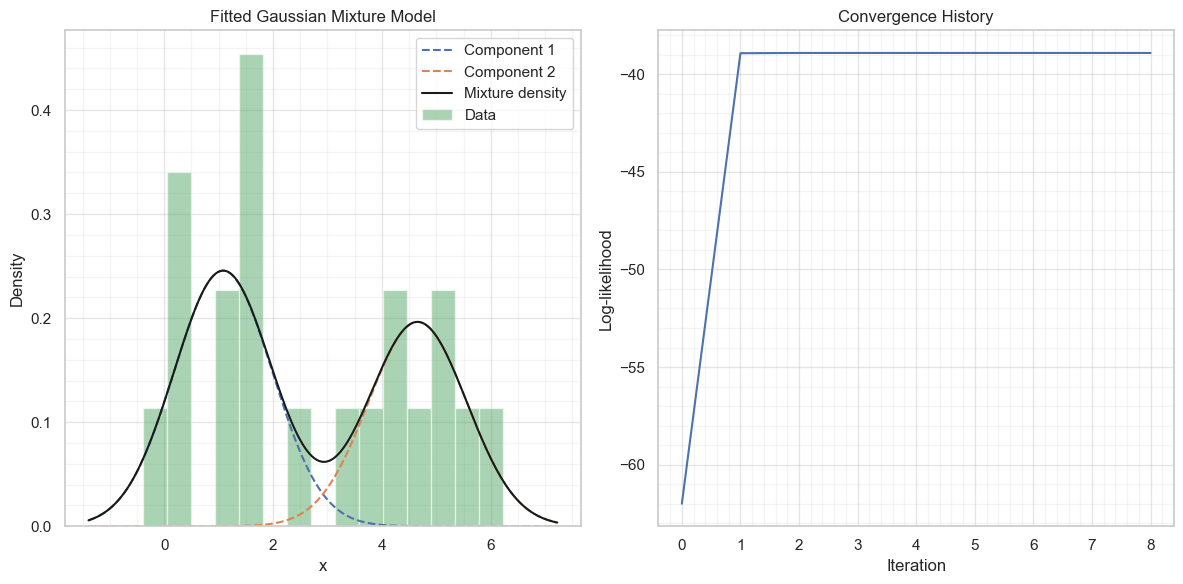

Final parameters:
Component 1:
  Mean: 1.083
  Standard deviation: 0.901
  Mixing coefficient: 0.555
Component 2:
  Mean: 4.656
  Standard deviation: 0.905
  Mixing coefficient: 0.445


In [4]:
def plot_mixture_model(data, mu, sigma, mixing_coefficients):
    """Plot the fitted Gaussian mixture model components and data histogram."""
    plt.figure(figsize=(12, 6))
    
    # Plot 1: Data and fitted components
    ax = plt.subplot(1, 2, 1)
    set_minor_grid(ax)  # Configure minor grid
    x = np.linspace(data.min() - 1, data.max() + 1, 200)
    
    # Plot individual components
    for k in range(2):
        component = mixing_coefficients[k] * norm.pdf(x, mu[k], sigma[k])
        plt.plot(x, component, '--', label=f'Component {k+1}')
    
    # Plot mixture density
    mixture = sum(mixing_coefficients[k] * norm.pdf(x, mu[k], sigma[k]) for k in range(2))
    plt.plot(x, mixture, 'k-', label='Mixture density')
    
    # Plot data points
    plt.hist(data, density=True, alpha=0.5, bins=15, label='Data')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.title('Fitted Gaussian Mixture Model')
    plt.legend()
    
def plot_convergence_history(history):
    """Plot the convergence history of the EM algorithm."""
    ax = plt.subplot(1, 2, 2)
    set_minor_grid(ax)  # Configure minor grid
    plt.plot(history)
    plt.xlabel('Iteration')
    plt.ylabel('Log-likelihood')
    plt.title('Convergence History')
    
def print_model_parameters(mu, sigma, mixing_coefficients):
    """Print the final parameters of the fitted model."""
    print('Final parameters:')
    for k in range(2):
        print(f'Component {k+1}:')
        print(f'  Mean: {mu[k]:.3f}')
        print(f'  Standard deviation: {sigma[k]:.3f}')
        print(f'  Mixing coefficient: {mixing_coefficients[k]:.3f}')

# Fit the model
mu, sigma, mixing_coefficients, history = em_gmm(data)

# Create visualization
plt.figure(figsize=(12, 6))
plot_mixture_model(data, mu, sigma, mixing_coefficients)
plot_convergence_history(history)
plt.tight_layout()
plt.show()

# Print the results
print_model_parameters(mu, sigma, mixing_coefficients)

Scikit-learn also has its own GaussianMixture class that uses EM under the hood.
Here is an implementation using that.

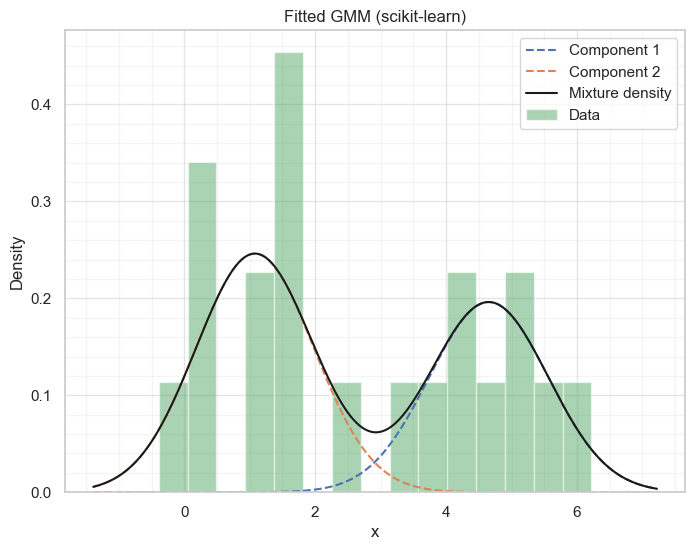

scikit-learn GMM parameters:
Component 1:
  Mean: 4.652
  Standard deviation: 0.908
  Mixing coefficient: 0.447
Component 2:
  Mean: 1.079
  Standard deviation: 0.897
  Mixing coefficient: 0.553


In [12]:
# Reshape the data for scikit-learn (needs 2D array)
X = data.reshape(-1, 1)

# Create and fit the model
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(X)

# Plot the results
plt.figure(figsize=(8, 6))
set_minor_grid(plt.gca())
x = np.linspace(data.min() - 1, data.max() + 1, 200).reshape(-1, 1)

# Plot individual components
for k in range(2):
    component = gmm.weights_[k] * norm.pdf(x, gmm.means_[k][0], np.sqrt(gmm.covariances_[k][0][0]))
    plt.plot(x, component, '--', label=f'Component {k+1}')

# Plot mixture density
mixture = gmm.score_samples(x)
mixture = np.exp(mixture)  # Convert from log probability to probability
plt.plot(x, mixture, 'k-', label='Mixture density')

# Plot data histogram
plt.hist(data, density=True, alpha=0.5, bins=15, label='Data')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Fitted GMM (scikit-learn)')
plt.legend()
plt.show()

# Print the results
print('scikit-learn GMM parameters:')
for k in range(2):
    print(f'Component {k+1}:')
    print(f'  Mean: {gmm.means_[k][0]:.3f}')
    print(f'  Standard deviation: {np.sqrt(gmm.covariances_[k][0][0]):.3f}')
    print(f'  Mixing coefficient: {gmm.weights_[k]:.3f}')

## 8.6 MCMC for Sampling from the Posterior

Gibbs sampling is a Markov chain Monte Carlo (MCMC) method that allows us to sample from the posterior of a Bayesian model.
Suppose that we wish to sample from the joint distribution of random variables $U_1, U_2, \ldots U_K$.
Suppose further that it is easy to sample from the conditional distributions $\text{P}\left(U_j \mid U_i, i\neq j\right)$ for $j=1, \ldots, K$.
The idea of Gibbs sampling is to alternatively sample from each of these distributions until the process stabilises, yielding a sample from the joint distribution.


This is related to the Gaussian mixture problem - we just need to consider the latent $\Delta_i$ to be parameters in the Gibbs sampler.
Running Gibbs sampling looks very similar to the EM algorithm except that at each stage we take samples rather than calculating maximum likelihood estimates.

Gibbs sampling is limited because it requires this specific structure.
Other methods, such as the Metropolis-Hastings algorithm, don't.

## 8.7 Bagging

**Regression**

Suppose we have a regression problem with training observations $(x_i, y_i)$, $i=1, \ldots, N$ independently drawn from a distribution $\mathcal{P}$ and an estimator $\hat{f}(x)$.
In an ideal world we could construct new estimators by sampling a new training set $(x_i^*, y_i^*)$ from $\mathcal{P}$ and fiting a new estimator $\hat{f}^*(x)$.
The $\hat{f}^*(x)$ are i.i.d. and so if each has variance $\sigma^2$ then the average of $B$ of them has the same bias and a variance of $\sigma^2 / B$.
By the bias-variance decomposition, true independent aggregation can only decrease the MSE of an estimator.
Note also that this will be more effective if the estimators have low bias and high variance.

In practice we can't sample new training sets from $\mathcal{P}$ and instead must sample from $\hat{\mathcal{P}}$ - the empirical distribution with equal probability on each data point $(x_i, y_i)$.
This gives us a bootstrap aggregation, or bagging, estimate:

\begin{equation}
    \hat{f}_{\text{bag}}(x) = \frac{1}{B} \sum_{b=1}^B \hat{f}^{*b}(x).
\end{equation}

Of course now the estimators are not independent.
But if they have variance $\sigma^2$ and positive pairwise correlation $\rho$, the variance of their average is (Exercise 15.1)

\begin{equation}
    \rho \sigma^2 + \frac{1 - \rho}{B} \sigma^2.
\end{equation}

So in practice bagging reduces the MSE, but this is limited by the correlation $\rho$ between bagging estimates.

The bagged estimate will only differ from the original estimate $\hat{f}(x)$ when the latter is a non-linear or adaptive function of the data.
So for B-splines the two are identical, but for regression trees they will be very different.

**Classification**

Now consider a classification problem.
We can either produce bagged estimates by consensus - take the class with the most bootstrap estimates - or averaging underlying class probabilities (if available).
The latter tends to produce bagged classifiers with lower variance, especially for small $B$.

*Note:* Voting proportions between bagged estimators do not approximate class probabilities.

Unlike for regression, bagging doesn't always improve classifiers.
With a 0-1 loss function (i.e. accuracy), bagging improves good classifiers but makes bad classifiers worse.
The book gives an instructive example for why bagging improves good classifiers.
Roughly, think of the individual estimators as i.i.d. Bernoulli variables.
The distribution of the aggregated estimate is the sample mean and has a limiting Normal distribution by the CLT.
As the number of estimators increases this becomes more concentrated around the expectation and so, if the individual estimators have a >50% chance of being right, then the probability of the aggregate estimator of being right tends to 1.

Again, in practice the boostrapped estimators are not independent.